# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
print(df.head())

   article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2  


In [216]:
print(df.shape) # 45993 rows and 3 columns

(45993, 3)


In [217]:
# Show df_content to get an idea of the data
print(df_content.head())

                                            doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLoading...\r\n\r...   

                                     doc_description  \
0  Detect bad readings in real time using Python ...   
1  See the forest, see the trees. Here lies the c...   
2  Here’s this week’s news in Data Science and Bi...   
3  Learn how distributed DBs solve the problem of...   
4  This video demonstrates the power of IBM DataS...   

                                       doc_full_name doc_status  article_id  
0  Detect Malfunctioning IoT Sensors with Streami...       Live           0  
1  Communicating data science: A guide to present...       Live           1  
2         This Week in Data Science (April 18, 2017)       Live           2  
3  DataLayer C

In [218]:
print(df_content.shape) # 1056 rows and 5 columns

(1056, 5)


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [219]:
print(df.isnull().sum()) # Sum of null entries by columns

article_id     0
title          0
email         17
dtype: int64


In [220]:
print(df.loc[df['email'].isnull()]) # Dataframe of the 17 null 'email' entries with other columns

       article_id                                              title email
25131      1016.0  why you should master r (even if it might even...   NaN
29758      1393.0                       the nurse assignment problem   NaN
29759        20.0  working interactively with rstudio and noteboo...   NaN
29760      1174.0      breast cancer wisconsin (diagnostic) data set   NaN
29761        62.0  data visualization: the importance of excludin...   NaN
35264       224.0                   using apply, sapply, lapply in r   NaN
35276       961.0                     beyond parallelize and collect   NaN
35277       268.0                      sector correlations shiny app   NaN
35278       268.0                      sector correlations shiny app   NaN
35279       268.0                      sector correlations shiny app   NaN
35280       268.0                      sector correlations shiny app   NaN
35281       415.0  using machine learning to predict value of hom...   NaN
35282       846.0        

In [221]:
print(df_content.isnull().sum()) # Sum of null entries by columns

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


In [222]:
print(df_content.loc[df_content['doc_body'].isnull()]) # Dataframe of the 14 null 'doc_body' entries with other columns

     doc_body                                    doc_description  \
206       NaN  Watch how to convert XML data to CSV format to...   
276       NaN  Love to work in Microsoft Excel? Watch how to ...   
484       NaN  See how to evaluate and convert your DDL and S...   
508       NaN  Watch how to generate SQL-based reports for Cl...   
540       NaN  Need to move some data to the cloud for wareho...   
638       NaN  See how to create a new dashDB instance and po...   
667       NaN  See how to connect dashDB, as a source and tar...   
706       NaN  Aginity Workbench is a free application known ...   
842       NaN  Learn how to configure a dashDB connection in ...   
876       NaN  See how to populate data into a table in your ...   
889       NaN  Watch how to apply association rules using R t...   
947       NaN  Watch how to extract and export dashDB data to...   
1037      NaN  See how quick and easy it is to set up a dashD...   
1054      NaN  Learn how to use IBM dashDB as da

In [223]:
print(df_content.loc[df_content['doc_description'].isnull()]) # Dataframe of the 3 null 'doc_description' entries with other columns

                                              doc_body doc_description  \
354  The search index lets you create flexible quer...             NaN   
768  Compose The Compose logo Articles Sign in Free...             NaN   
919  Cloudant Query is a powerful declarative JSON ...             NaN   

                                  doc_full_name doc_status  article_id  
354          Build the search index in Cloudant       Live         354  
768  Announcing the Data Browser for JanusGraph       Live         765  
919                  Use the new Cloudant query       Live         916  


In [224]:
most_viewed_art = df.loc[df['article_id']].value_counts()
print(most_viewed_art)

article_id  title                                                         email                                   
528.0       10 tips on using jupyter notebook                             7888dc37498447d0477be7ee2c4176543f5a6190    937
373.0       working with notebooks in dsx                                 3731e18b64e753dc509712c64bc8b219fb379a47    927
1396.0      times world university ranking analysis                       7277e817525abfd50b1f0f53b2b413ccc9336f58    671
732.0       rapidly build machine learning flows with dsx                 1c4b74e232865f95f25e28c91e1109be2b64004a    643
151.0       jupyter notebook tutorial                                     7dc02db8b76fffbdfe29542da672d4d5fd5ed4ae    627
                                                                                                                     ... 
1364.0      predicting churn with the spss random tree algorithm          21a68f0bfaedf3ce97d85100b618c1635a83ce17      1
766.0       making data science

In [225]:
def num_of_users(min, max, col='email'):
    '''
    This function filters out the users in 'user-item-interactions.csv' dataset by their emails, without repetition.
    
    Params:
    1. min (int): Minimum index of the list of users you want to view. Should not be less than zero.
    2. max (int): Maximum index of the list of users you want to view. Should not be greater than 5149.
    3. col (DataFrame): Specifically chosen as the email column of the 'user-item-interactions.csv' dataset.
    
    Returns:
    1. tot_users (list): A list of all the user emails without repetition.
    2. len_tot_users (int): The total number of users.
    3. choose_users (list): List of emails of a chosen number of users.
    '''
    df_email = df[col]
    user_list = list(df_email)
    tot_users = list(df_email.unique())
    len_tot_users = len(tot_users)
    if min > len_tot_users or max > len_tot_users:
        print("'max' must not be greater than {}.".format(len_tot_users))
    elif min < 0 or max < 0:
        print("'min' or 'max' must not be negative.")
    elif min > max:
        print("'min' must be less than 'max'")
    else:
        choose_users = tot_users[min:max]
        return tot_users, len_tot_users, choose_users
    
    
users, no_of_users, some_users = num_of_users(5147, 5149)

# Choose a range of users to view their emails
print(some_users)

['abbf639ba05daa5249c520e290283a6d726ba78d', '1f18e8aaccd6c8720180c3fe264c8aef5b00697f']


In [226]:
# List of users by their emails
print(users)

['ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7', '083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b', 'b96a4f2e92d8572034b1e9b28f9ac673765cd074', '06485706b34a5c9bf2a0ecdac41daf7e7654ceb7', 'f01220c46fc92c6e6b161b1849de11faacd7ccb2', 'b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5', '3c2de1b0a92728aa53064a22ff7bd7319878ed95', '3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea', '8b6fb4bbb7a27b336ba35420bf58337d877455c7', '35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4', 'fc4e4290f2f320d80711bbe019618cc5be8815fa', 'de6333cc934b9b7663ea38ca7cf13d59a4baae3b', '5e8b6eea25188b0516fc111a32daa59a4419f767', 'f44787ebd5330e097a1ee8aea81d970200e912bb', 'ec123f6658890db92d7db29a04c03e5e2098fa43', '9ac67534404850b3850c331c66e9233504ec5eaa', '011ae4de07ffb332b0f51c155a35c23c80294962', 'f0d738c18e8ef4736beabea9db813cd86cc5a148', '737e9353c4266ccaa254acfd611024741a923842', '07545b0e6624cdfb2c81a17624c9326a1371c446', '8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e', 'b6926a8fa3ece411773bfba65c455fb15df4d6c6', '2b6c0f514c2f2b04ad3c4583407dcc

In [227]:
# Total number of users witout repetition
print(no_of_users)

5149


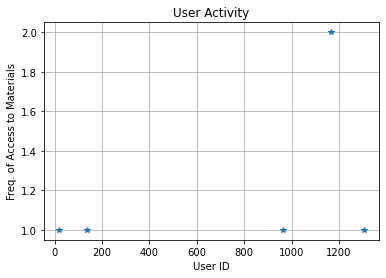

Use 'max' value as: 5


Articles used are:

 article_id  title                                                  
962.0       data visualization with r: scrum metrics                   2
1305.0      gosales transactions for naive bayes model                 1
1165.0      analyze precipitation data                                 1
138.0       best packages for data manipulation in r                   1
20.0        working interactively with rstudio and notebooks in dsx    1
dtype: int64


Total number of times user accessed all articles: 6


In [228]:
def user_article_use(user_email, min, max):
    '''
    This function extracts the number of times each user of choice, accessed each article in 'user-item-interactions.csv' 
    dataset, and the total number of articles accessed on the whole.
    
    Param:
    1. user_email (str): Any user email of choice from the email list. Must be wrapped in a quotation sign.
    2. min (int): Minimum value from where one wishes to start plotting the graph. Must not be less than zero.
    3. max (int): Maximum value where one wishes to stop the graph. To know the maximum allowable 'max' value, one can just 
    choose min=0 and max=1 at first. The actual max value shows immediately under the graph.
    
    Returns:
    1. art_used (DataFrame): A dataframe of the articles accessed with the frequency of access of each.
    2. num_of_art (int): The total number of times the user accessed items on the whole.
    3. only_art (list): A lst of all the articles accessed, without repetition. The length of this list, is the maximum 
    allowable 'max' value.
    4. plt.show() (graph): A graph of points, showing that accessed article_id with the frequency of access of each article
    for the number of occasions of visit, selected.
    '''
    art_used = df.loc[(df['email'] == user_email), ['article_id', 'title']].value_counts()
    num_of_art = df.loc[(df['email'] == user_email), ['article_id']].shape[0]
    art_val = list(df.loc[(df['email'] == user_email), ['article_id']].value_counts())
    only_arts = df.loc[(df['email'] == user_email), ['article_id']]
    only_art = list(only_arts['article_id'].unique())
    
    if min < 0:
        print("'min' must not be negative.")
    elif min > len(art_val) or max > len(art_val):
        print("'min' or 'max' must not be greater than {}.".format(len(art_val)))
    elif max < 0:
        print("'max' must not be negative.")
    elif min > max:
        print("'min' must be less than 'max'")
    else:
        art_val = art_val[min:max]
        my_only_art = only_art[min:max]
        
        plt.plot(my_only_art, art_val, '*')
        plt.xlabel('User ID')
        plt.ylabel('Freq. of Access to Materials')
        plt.title('User Activity')
        plt.grid()
        plt.show()

        return art_used, num_of_art, only_art, plt.show()

art_used, num_of_art, only_art, plotting = user_article_use('1b7a3f70a30b90837681376d48c1ae8832f9834b', 0, 5)

print("Use 'max' value as: {}\n\n".format(len(only_art)))
print('Articles used are:\n\n {}'.format(art_used))
print('\n\nTotal number of times user accessed all articles: {}'.format(num_of_art))

In [229]:
# Total number of times a user accessed all articles.
print('Total number of times a user accessed all articles: {}'.format(num_of_art))

Total number of times a user accessed all articles: 6


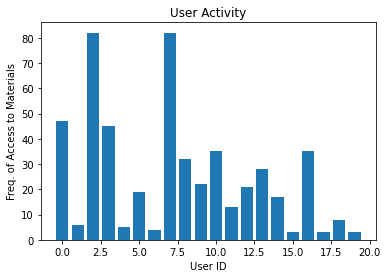

In [230]:
def user_visual(min, max):
    '''
    This fucntion produces a new dataframe of the users with their individual frequency of access to articles. One can input a
    range of users to view their frequencies of access on a bar chart, using the min and max parameters.
    
    Params:
    1. min (int): Minimum value of user_id. Must not be less than zero.
    2. max (int): Maximum value of user_id. Must not be greagter than 5149.
    
    Returns:
    1. new_df (DataFrame): A new dataframe containing user_email, user_ids and user_freq.
    2. stats (DataFrame): A dataframe of statistics of all the users.
    3. plt.show() (Barchart): A barchart of the selected users, showing their frequencies of access.
    '''
    email_dict = {}
    for emails in df['email']:
        if emails in email_dict:
            email_dict[emails] += 1
        else:
            email_dict[emails] = 1

    x_val = list(email_dict.keys())
    y_val = list(email_dict.values())
    uid = list(np.arange(0, len(x_val)))
    
    if min > len(x_val) or max > len(x_val):
        print("'min' or 'max' must not be greater than {}.".format(len(x_val)))
    elif min < 0 or max < 0:
        print("'min' or 'max' must not be negative.")
    elif min > max:
        print("'min' must be less than 'max'")
    else:
        new_df = pd.DataFrame({'user_email': x_val, 'user_ids': uid, 'user_freq': y_val})
        stats = new_df.describe()

        uid = uid[min:max]
        y_val = y_val[min:max]

        plt.bar(uid, y_val)
        plt.xlabel('User ID')
        plt.ylabel('Freq. of Access to Materials')
        plt.title('User Activity')
        return new_df, stats, plt.show()


new_df, stats, plots = user_visual(0, 20)

In [231]:
print(new_df)

                                    user_email  user_ids  user_freq
0     ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7         0         47
1     083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b         1          6
2     b96a4f2e92d8572034b1e9b28f9ac673765cd074         2         82
3     06485706b34a5c9bf2a0ecdac41daf7e7654ceb7         3         45
4     f01220c46fc92c6e6b161b1849de11faacd7ccb2         4          5
...                                        ...       ...        ...
5144  1b7a3f70a30b90837681376d48c1ae8832f9834b      5144          6
5145  d21b998d7a4722310ceeaa3c6aaa181a36db2d73      5145          9
5146  4faeed980a7cd11e0f3cf2058cc04daa2ef11452      5146          1
5147  abbf639ba05daa5249c520e290283a6d726ba78d      5147          1
5148  1f18e8aaccd6c8720180c3fe264c8aef5b00697f      5148          1

[5149 rows x 3 columns]


In [232]:
print(stats)

          user_ids    user_freq
count  5149.000000  5149.000000
mean   2574.000000     8.932414
std    1486.532599    16.801011
min       0.000000     1.000000
25%    1287.000000     1.000000
50%    2574.000000     3.000000
75%    3861.000000     9.000000
max    5148.000000   364.000000


In [233]:
def new_df_range(min, max):
    '''
    With this function, one can choose a range of users to view their frequency of access to the articles.
    
    Params:
    1. min (int): Starting index number. Must not be less than zero.
    2. max (int): Ending index number. Must not be greater than 5149.
    
    Returns:
    new_df (DataFrame): A dataframe of the user_email, user_ids and user_freq
    '''
    if min > new_df.shape[0] or max > new_df.shape[0]:
        print("'min' or 'max' must not be greater than {}.".format(new_df.shape[0]))
    elif min < 0 or max < 0:
        print("'min' or 'max' must not be negative.")
    elif min > max:
        print("'min' must be less than 'max'")
    else:
        return new_df.iloc[min:max]

new_df_range(1, 4)

,user_email,user_ids,user_freq
1,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,1,6
2,b96a4f2e92d8572034b1e9b28f9ac673765cd074,2,82
3,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,3,45


In [234]:
# Dataframe of user(s) with highest number of access to articles
highest = new_df['user_freq'].max()

highest_df = new_df.loc[(new_df['user_freq'] == highest), ['user_email', 'user_ids', 'user_freq']]
print(highest_df)

                                  user_email  user_ids  user_freq
22  2b6c0f514c2f2b04ad3c4583407dccd0810469ee        22        364


In [235]:
# Dataframe of user(s) with least number of access to articles
least = new_df['user_freq'].min()

least_df = new_df.loc[(new_df['user_freq'] == least), ['user_email', 'user_ids', 'user_freq']]
print(least_df)

                                    user_email  user_ids  user_freq
28    044e0e49589bc60c0e3a4e8a2723b774d4fa1f8d        28          1
46    b3b884da0f386758459539036cb23ddacb6c1173        46          1
92    f331c486a4e648cfe41ffbb93eeaecaabc17c914        92          1
98    37943b1d038fc564a54b86ec7babcbdab0cd85ba        98          1
100   61f2a8f3c0a6335542feed8cc95038c96ed97668       100          1
...                                        ...       ...        ...
5140  a3f94d0fa042638f6ae5cdcd028e6d87884f1ee4      5140          1
5143  aee3c105b56256124382cd74624a993f2e840b6f      5143          1
5146  4faeed980a7cd11e0f3cf2058cc04daa2ef11452      5146          1
5147  abbf639ba05daa5249c520e290283a6d726ba78d      5147          1
5148  1f18e8aaccd6c8720180c3fe264c8aef5b00697f      5148          1

[1416 rows x 3 columns]


In [236]:
def least_df_range(min, max):
    '''
    This function provides the users with the least frequency of access to the articles. Each of them accessed the articles
    only once and they are 1416 in total. With this function, one can choose a range of users to view their 
    email and user_id.
    
    Params:
    1. min (int): Starting index number. Must not be less than zero.
    2. max (int): Ending index number. Must not be greater than 1416.
    
    Returns:
    new_df (DataFrame): A dataframe of the user_email, user_ids and user_freq
    '''
    if min > least_df.shape[0] or max > least_df.shape[0]:
        print("'min' or 'max' must not be greater than {}.".format(least_df.shape[0]))
    elif min < 0 or max < 0:
        print("'min' or 'max' must not be negative.")
    elif min > max:
        print("'min' must be less than 'max'")
    else:
        return least_df.iloc[0:5]

print(least_df_range(1, 5))

                                   user_email  user_ids  user_freq
28   044e0e49589bc60c0e3a4e8a2723b774d4fa1f8d        28          1
46   b3b884da0f386758459539036cb23ddacb6c1173        46          1
92   f331c486a4e648cfe41ffbb93eeaecaabc17c914        92          1
98   37943b1d038fc564a54b86ec7babcbdab0cd85ba        98          1
100  61f2a8f3c0a6335542feed8cc95038c96ed97668       100          1


In [237]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(list(new_df['user_freq'])) # 50% of individuals interact with 3 articles or fewer.
print(median_val)

3.0


In [238]:
max_views_by_user = new_df['user_freq'].max() # The maximum number of user-article interactions by any 1 user is 364.
print(max_views_by_user)

364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [239]:
# Find and explore duplicate articles

df_content_dup = df_content.duplicated(['article_id']).sum()
print(df_content_dup)

5


In [240]:
# Find and explore duplicate articles

df_content_dup_set = df_content.loc[(df_content.duplicated(['article_id']))]
print(df_content_dup_set)

                                              doc_body  \
365  Follow Sign in / Sign up Home About Insight Da...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
365  During the seven-week Insight Data Engineering...   
692  One of the earliest documented catalogs was co...   
761  Today’s world of data science leverages data f...   
970  This video shows you how to construct queries ...   
971  If you are like most data scientists, you are ...   

                                         doc_full_name doc_status  article_id  
365                       Graph-based machine learning       Live          50  
692  How smart catalogs can turn the big data flood...       Live         221  
761  Using Apache Spark as a parallel processing fr...       L

In [241]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')
print(df_content)

                                               doc_body  \
0     Skip navigation Sign in SearchLoading...\r\n\r...   
1     No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3     DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4     Skip navigation Sign in SearchLoading...\r\n\r...   
...                                                 ...   
1051  PouchDB-find is a new API and syntax that allo...   
1052  We compare discriminative and generative learn...   
1053  Essays about data, building products and boots...   
1054                                                NaN   
1055  Homepage Follow Sign in / Sign up Homepage * H...   

                                        doc_description  \
0     Detect bad readings in real time using Python ...   
1     See the forest, see the trees. Here lies the c...   
2     Here’s this week’s news in Data Science and Bi...   
3     Learn how distributed DBs solve the problem of...

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [242]:
print(df.head())

   article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2  


In [243]:
# The number of unique articles that have at least one interaction

unique_articles = df.article_id.nunique()
print(unique_articles)

714


In [244]:
# The number of user-article interactions

user_article_interactions = df['email'].shape[0]
print(user_article_interactions)

45993


In [245]:
df1 = df.dropna() # Delete missing values and their records

df1 = df1.drop_duplicates(subset=['email'], keep='first') # Drop duplicates, leaving only the first records

In [246]:
# The number of unique users

unique_users = df1.email.nunique()
print(unique_users )

5148


In [247]:
# The number of unique articles on the IBM platform

total_articles = df_content.article_id.nunique()
print(total_articles)

1051


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [248]:
# The most viewed article in the dataset as a string with one value following the decimal

most_viewed_article_id =  df['article_id'].value_counts()
print(most_viewed_article_id.head())

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64


In [249]:
most_viewed_article_id = '1429.0'
print(most_viewed_article_id)

1429.0


In [250]:
# The most viewed article in the dataset was viewed how many times?

max_views = list(df['article_id'].value_counts())[0]
print(max_views)

937


In [251]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [252]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [253]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = (df['title'].value_counts().reset_index()).rename(
        columns={'index': 'title', 'title': 'freq'}).head(n)
    top_articles = list(top_articles['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = (df['article_id'].value_counts().reset_index()).rename(
        columns={'index': 'article_id', 'article_id': 'freq'}).head(n)
    top_articles = list(top_articles['article_id'])
 
    return top_articles # Return the top article ids

In [254]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [255]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [256]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df['access'] = 1
    user_group = df.groupby(['user_id', 'article_id'])['access'].max()
    user_item = user_group.unstack()
    user_item.fillna(0, inplace=True)   
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
print(user_item)

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3              0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
4              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
5145           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5146           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5147           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5148           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5149           0.0     0.0     0.0     0.0     0.0     0.0     0

In [257]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [258]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    like_user = {}
    no_of_users = user_item.shape[0]

    for num in range(1, no_of_users + 1):
        like_user[num] = np.dot(user_item.loc[user_id], np.transpose(user_item.loc[num]))
        
    # sort by similarity
    sorted_like_user = pd.DataFrame.from_dict(like_user, orient = 'index').sort_values(0, ascending=False)

    # create list of just the ids
    most_similar_users = list(sorted_like_user.index)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [259]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [260]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    intersect = user_item.loc[user_id][user_item.loc[user_id] == 1]
    article_ids = intersect.index.astype('str').to_list()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = []
    seen_art_ids, seen_art_titles = get_user_articles(user_id)
    close_users = find_similar_users(user_id)
    
    for close_user in close_users:
        art_ids, art_titles = get_user_articles(close_user)
        init_recs = np.setdiff1d(art_ids, seen_art_ids)
        recs.extend(np.setdiff1d(init_recs, recs))
        
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [261]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze facebook data using ibm watson and watson studio',
 'analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'airbnb data for analytics: vancouver listings',
 'data tidying in data science experience',
 'airbnb data for analytics: mallorca reviews',
 'a tensorflow regression model to predict house values',
 'recommender systems: approaches & algorithms',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object']

In [262]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [263]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # Article dot product
    art_prod = user_item.dot(np.transpose(user_item))
    sim_df = art_prod.loc[user_id].sort_values(ascending = False) 
    
    # Reset the similarity dataframe
    sim_df = pd.DataFrame(sim_df.reset_index().drop(0, axis =0))
    sim_df['similarity_level'] = sim_df[user_id]
    sim_df.drop(user_id, axis=1, inplace=True)
    
    # Calculate the neighbors
    neighbors = df['user_id'].value_counts()
    neighbors = pd.DataFrame(neighbors).reset_index().rename(
        columns={'index': 'user_id', 'user_id': 'interations'})
    
    # Merge the similarity and neighbors dataframes
    neighbors = sim_df.merge(neighbors, on=['user_id'], how='outer')
    neighbors_df = neighbors.sort_values(by=['similarity_level', 'interations'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    my_recs = []
    
    seen_ids, seen_titles = get_user_articles(user_id)
    sim_users = get_top_sorted_users(user_id)
    
    for users in sim_users['user_id'].values:
        new_seen_ids, new_seen_titles = get_user_articles(users)
        
        # Drop articles already seen by user
        matched_ids = np.setdiff1d(new_seen_ids, seen_ids)
        matched_ids = np.setdiff1d(matched_ids, my_recs)
        
        # Sort rest articles by popularity
        matched_ids = df[df['article_id'].isin(matched_ids)].groupby(
            'article_id').count().sort_values('title', ascending = False).index.to_list()
        my_recs.extend(matched_ids)
        
    recs = my_recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names


In [264]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'analyze energy consumption in buildings', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'movie recommender system with spark machine learning', 'analyze accident reports on amazon emr spark', 'model bike sharing data with spss', 'apache spark lab, part 1: basic concepts']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [265]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1
user1_most_sim = list(get_top_sorted_users(1)['user_id'])[0]

# Find the 10th most similar user to user 131
user131_10th_sim = list(get_top_sorted_users(131)['user_id'])[9]

In [266]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

**None of the above functions will be able to make recommendations directly for a new user. 'Cold Start' problem will be encountered if an attempt is made, because the user has not had an interaction with any of the articles in the dataset. To make recommendations for such a user, I would first use the 'get_top_article_ids' function to enable them have some interactions with the articles.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [267]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = np.array(get_top_article_ids(10)).astype(str)# Your recommendations here
print(new_user_recs)

['1429.0' '1330.0' '1431.0' '1427.0' '1364.0' '1314.0' '1293.0' '1170.0'
 '1162.0' '1304.0']


In [268]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [269]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [270]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [271]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True) # use the built in to get the three matrices

print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


**Provide your response here.**<br><br>
**This is different than in the lesson because the dataframe in the lesson has got a NAN value while this dataframe has not got a NAN value. So we can easily use the SVD technique here without encountering a 'Cold Start' problem.**

**- u is a square matrix of 5149 rows by 5149 columns.**<br>
**- s is an array of 714 elements.**<br>
**- vt is a square matrix of 714 rows by 714 columns.**<br>

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

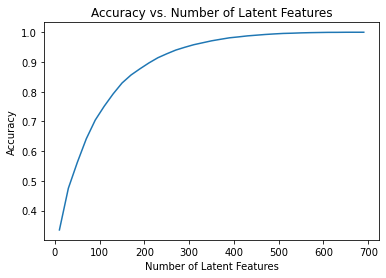

In [272]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [273]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    # The train dataset
    df_train = df_train[['user_id', 'article_id', 'access']]
    user_item_train = df_train.groupby(['user_id', 'article_id']).max().unstack().fillna(0)
        
    # The test dataset
    df_test = df_test[['user_id', 'article_id', 'access']]
    user_item_test = df_test.groupby(['user_id', 'article_id']).max().unstack().fillna(0)
        
    test_idx = user_item_test.index
    
    test_arts = user_item_test.columns.levels[1]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [274]:
# How many users can we make predictions for in the test set?
test_pred = len(set(test_idx).intersection(list(user_item_train.index)))
print(test_pred)

20


In [275]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
no_test_pred = len(set(test_idx)) - test_pred
print(no_test_pred)

662


In [276]:
# How many articles can we make predictions for in the test set?
art_pred = len(set(test_arts).intersection(list(user_item_train.columns.levels[1])))
print(art_pred)

574


In [277]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
no_art_pred = len(test_arts) - art_pred
print(no_art_pred)

0


In [278]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [279]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True) # fit svd similar to above then use the cells below

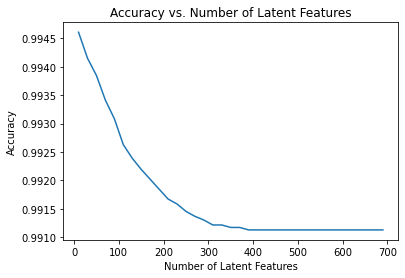

In [280]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    
    # Restructure with k latent features
    u_train_new, s_train_new, vt_train_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    
    u_intersect = user_item_train.index.isin(test_idx)
    u_matrix = u_train[u_intersect, :]
    
    vt_intersect = user_item_train.columns.levels[1].isin(test_arts)
    vt_matrix = vt_train[:, vt_intersect]
    
    u_matrix_new, vt_matrix_new = u_matrix[:, :k], vt_matrix[:k, :]
        
    # Take dot product
    user_item_est = np.around(np.dot(np.dot(u_matrix_new, s_train_new), vt_matrix_new))
        
    # Compute error for each prediction to actual value
    
    init_intersect = user_item_test.index.isin(user_item_train.index[u_intersect])
    mid_intersect = user_item_test.index[init_intersect]
    
    diffs = np.subtract(user_item_test.loc[mid_intersect], user_item_est)
    
    # Total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**<br><br>
**From the above analysis, the prediction accuracy decreases as the number of latent features increases. This implies that the SVD is not very suitable for datasets with very many latent features.**<br>

**To determine whether my recommendations are an improvement, I will carry out an experiment, preferrably with A/B testing. It will also be helpful to design the experiment in such a way that it will attract greater number of user-article interactions.**

In [281]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1